In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [2]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'
idx_features_labels = np.genfromtxt(folder_dir + '/cora.content',dtype=np.str)
edges_unordered = np.genfromtxt(folder_dir + '/cora.cites',dtype=np.int)

Mounted at /content/drive


In [109]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        self.node_connection = np.empty_like(edge)
        self.node_adj = np.zeros((data.shape[0], data.shape[0]), dtype=np.int)

        for i, (cited, citing) in enumerate(edge):
            self.node_connection[i] = (self.paper2node[cited], self.paper2node[citing])
            self.node_adj[self.node_connection[i][0]][self.node_connection[i][1]] = 1

    def get_dataset(self):

        node_x = np.array(self.node_feature, dtype=np.int32)
        node_y = np.array(self.node_label, dtype=np.int32)
        adjmat = np.array(self.node_adj, dtype=np.int32)
        return node_x, node_y, adjmat
        

cora = Cora(base_dir='/content/drive/My Drive')


# refered by kif github
def gcn_adj_normalization(adjmat):
    for i in range(len(adjmat)):
        for j in range(i + 1, len(adjmat)):
            if adjmat[i][j] > 0:
                adjmat[j][i] = 1
            elif adjmat[j][i] > 0:
                adjmat[i][j] = 1
    adjmat = adjmat.astype(np.float)
    adjmat += np.eye(len(adjmat))
    dig_rsqrt = np.power(adjmat.sum(axis=1), -0.5)
    dig_rsqrt[np.isinf(dig_rsqrt)] = 0.
    dig_rsqrt = np.diag(dig_rsqrt)
    return dig_rsqrt @ adjmat @ dig_rsqrt



node_x, node_y, adjmat = cora.get_dataset()

gcn_adj = gcn_adj_normalization(adjmat)

In [110]:
def xavier_weight(*size):
    return torch.nn.init.xavier_uniform_(torch.empty(*size))

class GraphConvolution(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.weight = nn.Parameter(xavier_weight(n_in, n_out))
        
    def forward(self, A, x):
        return torch.matmul(A, torch.matmul(x, self.weight))
    

class GCNBlock(nn.Module):
    def __init__(self, n_in, n_out, p):
        super().__init__()
        self.gcn = GraphConvolution(n_in, n_out)
        self.act = nn.LeakyReLU(0.05)
        self.dropout = nn.Dropout(p) 
        
    def forward(self, A, x):
        x = self.gcn(A, x)
        x = self.dropout(x)
        x = self.act(x)
        return x



class GCN(nn.Module):
    def __init__(self, n_in, n_hid, n_out):
        super().__init__()
        self.layer_in = nn.Linear(n_in, n_hid)
        self.layer = nn.ModuleList([
            GCNBlock(n_hid, n_hid, 0.5),
            GCNBlock(n_hid, n_hid, 0.5),
            GCNBlock(n_hid, n_hid, 0.5),
        ])        
        self.layer_out = GraphConvolution(n_hid, n_out)

    
    def forward(self, A, h):
        h = self.layer_in(h)
        for gcn in self.layer:
            h = h + gcn(A, h)
        h = self.layer_out(A, h)
        return h

In [113]:
A = torch.Tensor(gcn_adj)
X = torch.Tensor(node_x.astype(np.float)) / X.sum(dim=1, keepdim=True)
target = torch.LongTensor(node_y)

In [114]:
idx_train = range(200)
idx_test = range(200, len(X))
idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)

model = GCN(n_in=len(node_x[0]), n_hid=128, n_out=7)
solver = optim.Adam(model.parameters(),  lr=1e-3)

In [115]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(200):
    solver.zero_grad()
    Y = model(A, X)
    loss = F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean')
    loss.backward()
    solver.step()
    with torch.no_grad():
        model.eval()
        Y = model(A, X)
        train_loss.append(F.cross_entropy(Y[idx_train], target[idx_train], reduction='mean').item())
        test_loss.append(F.cross_entropy(Y[idx_test], target[idx_test], reduction='mean').item())
        train_acc.append((Y[idx_train].argmax(dim=1) == target[idx_train]).sum().item() / len(idx_train))
        test_acc.append((Y[idx_test].argmax(dim=1) == target[idx_test]).sum().item() / len(idx_test))
        model.train()


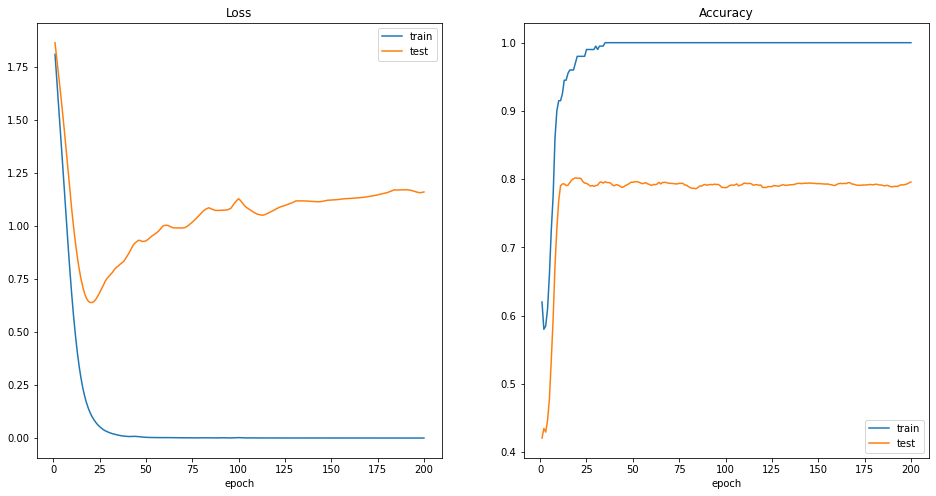

train loss :  0.00015746969438623637
test loss :  1.1606485843658447
train accuracy :  1.0
test accuracy :  0.79585326953748


In [116]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(range(1, len(train_loss) + 1), train_loss, label='train')
ax.plot(range(1, len(test_acc) + 1), test_loss, label='test')

ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.legend()

ax = f.add_subplot(1,2,2)
ax.plot(range(1, len(train_acc) + 1), train_acc, label='train')
ax.plot(range(1, len(test_acc) + 1), test_acc, label='test')
ax.set_title('Accuracy')
ax.set_xlabel('epoch')

ax.legend()
plt.show()
print('train loss : ', train_loss[-1])
print('test loss : ', test_loss[-1])
print('train accuracy : ', train_acc[-1])
print('test accuracy : ', test_acc[-1])

In [118]:
model.eval()
predicted = torch.argmax(model(A, X), dim=1).detach().cpu().numpy()

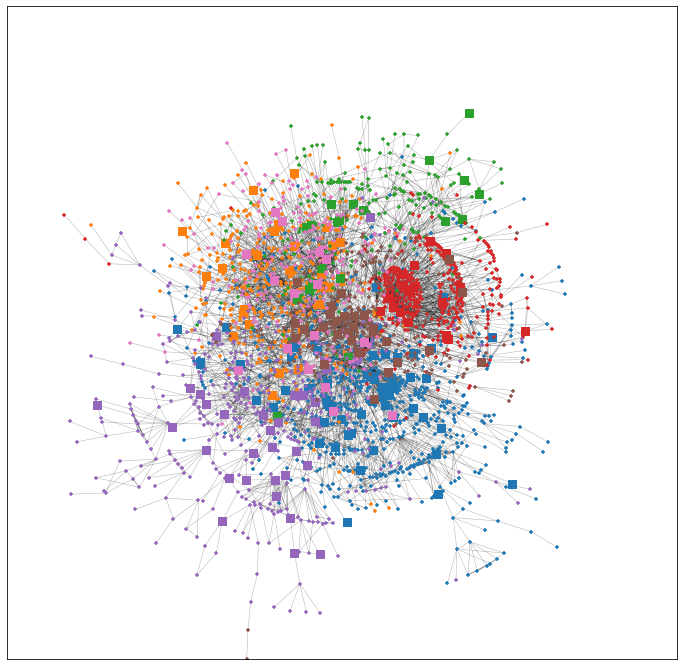

In [120]:
G = nx.Graph()
G.add_edges_from(cora.node_connection)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(12, 12))
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple','tab:brown', 'tab:pink']

for i, label in enumerate(range(7)):
    nx.draw_networkx_nodes(G, # given node
                           pos,
                           nodelist=[idx for idx in idx_train.numpy() if predicted[idx] == label],
                           node_color=color_list[i],
                           node_size=50,
                           node_shape='s',
                           alpha=1.0)
    
    nx.draw_networkx_nodes(G, # test node
                           pos,
                           nodelist=[idx for idx in idx_test.numpy() if predicted[idx] == label],
                           node_color=color_list[i],
                           node_size=10,
                           node_shape='+',
                           alpha=1.0
                           )
    

nx.draw_networkx_edges(G,pos, width=0.5, alpha=0.3,edge_color='#000000')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()